### Required Assignment 5.1: Will the Customer Accept the Coupon?

**Context**

Imagine driving through town and a coupon is delivered to your cell phone for a restaurant near where you are driving. Would you accept that coupon and take a short detour to the restaurant? Would you accept the coupon but use it on a subsequent trip? Would you ignore the coupon entirely? What if the coupon was for a bar instead of a restaurant? What about a coffee house? Would you accept a bar coupon with a minor passenger in the car? What about if it was just you and your partner in the car? Would weather impact the rate of acceptance? What about the time of day?

Obviously, proximity to the business is a factor on whether the coupon is delivered to the driver or not, but what are the factors that determine whether a driver accepts the coupon once it is delivered to them? How would you determine whether a driver is likely to accept a coupon?

**Overview**

The goal of this project is to use what you know about visualizations and probability distributions to distinguish between customers who accepted a driving coupon versus those that did not.

**Data**

This data comes to us from the UCI Machine Learning repository and was collected via a survey on Amazon Mechanical Turk. The survey describes different driving scenarios including the destination, current time, weather, passenger, etc., and then ask the person whether he will accept the coupon if he is the driver. Answers that the user will drive there 'right away' or 'later before the coupon expires' are labeled as 'Y = 1' and answers 'no, I do not want the coupon' are labeled as 'Y = 0'.  There are five different types of coupons -- less expensive restaurants (under \$20), coffee houses, carry out & take away, bar, and more expensive restaurants (\$20 - $50).

**Deliverables**

Your final product should be a brief report that highlights the differences between customers who did and did not accept the coupons.  To explore the data you will utilize your knowledge of plotting, statistical summaries, and visualization using Python. You will publish your findings in a public facing github repository as your first portfolio piece.

In [1]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Color palette for consistent styling
COLORS = {
    'accept': '#81C784',
    'reject': '#E57373',
    'primary': '#BA68C8',
    'secondary': '#FFD54F',
    'tertiary': '#64B5F6'
}

### 1. Read in the `coupons.csv` file

In [2]:
data = pd.read_csv('data/coupons.csv')
data.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


### 2. Investigate the dataset for missing or problematic data

In [3]:
# Data Quality Investigation
df = pd.read_csv('data/coupons.csv')

print("="*80)
print("DATA QUALITY INVESTIGATION")
print("="*80)
print(f"Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

# 1. Missing Data
print("1. MISSING DATA")
print("-"*80)
missing_count = df.isnull().sum()
missing_percent = (missing_count / len(df)) * 100
missing_df = pd.DataFrame({'Count': missing_count, '%': missing_percent})
print(missing_df[missing_df['Count'] > 0].sort_values('%', ascending=False))
print(f"\nTotal: {missing_count.sum()}\n")

# 2. Duplicates
print("2. DUPLICATES")
print("-"*80)
dup_count = df.duplicated().sum()
print(f"Duplicate rows: {dup_count} ({dup_count/len(df)*100:.2f}%)\n")

# 3. Logical Consistency
print("3. LOGICAL CHECKS")
print("-"*80)
print("✓ direction_same + direction_opp = 1" if (df['direction_same'] + df['direction_opp']).nunique() == 1 else "⚠ Direction flags inconsistent")
print("✓ Distance flags consistent" if len(df[(df['toCoupon_GEQ25min'] == 1) & (df['toCoupon_GEQ15min'] == 0)]) == 0 else "⚠ Distance flags illogical")

print("\n" + "="*80)
print("KEY ISSUES")
print("="*80)
print(f"• 'car' column: 99% missing → DROP")
print(f"• {dup_count} duplicates concentrated in Work/7AM/Carry-out segment")
print(f"• {len(missing_df[missing_df['Count'] > 0])} columns with <2% missing data")

DATA QUALITY INVESTIGATION
Dataset Shape: 12684 rows × 26 columns

1. MISSING DATA
--------------------------------------------------------------------------------
                      Count          %
car                   12576  99.148534
CoffeeHouse             217   1.710817
Restaurant20To50        189   1.490066
CarryAway               151   1.190476
RestaurantLessThan20    130   1.024913
Bar                     107   0.843582

Total: 13370

2. DUPLICATES
--------------------------------------------------------------------------------
Duplicate rows: 74 (0.58%)

3. LOGICAL CHECKS
--------------------------------------------------------------------------------
✓ direction_same + direction_opp = 1
✓ Distance flags consistent

KEY ISSUES
• 'car' column: 99% missing → DROP
• 74 duplicates concentrated in Work/7AM/Carry-out segment
• 6 columns with <2% missing data


### 3. Data Cleaning Strategy

**Actions:**
1. Drop 'car' column (99% missing)
2. Remove 74 duplicate rows
3. Remove rows with missing frequency data (~5%)

**Risk:** Duplicates concentrated in Work/7AM segment may slightly underrepresent morning commuters.

**Recommendations for data collection:**
- Fix car column collection
- Implement duplicate detection at submission
- Make frequency columns mandatory

In [4]:
# Data Cleaning
print("Starting shape:", df.shape)

df_clean = df.drop('car', axis=1)
print(f"After dropping 'car': {df_clean.shape}")

df_clean = df_clean.drop_duplicates()
print(f"After removing duplicates: {df_clean.shape}")

freq_cols = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
df_clean = df_clean.dropna(subset=freq_cols)
print(f"After removing missing frequency data: {df_clean.shape}")

print(f"\n✓ Removed {len(df) - len(df_clean)} rows ({(len(df) - len(df_clean))/len(df)*100:.1f}%)")
print(f"✓ No missing values: {df_clean.isnull().sum().sum() == 0}")
print(f"✓ No duplicates: {df_clean.duplicated().sum() == 0}")

df_clean.to_csv('data/coupons_cleaned.csv', index=False)

Starting shape: (12684, 26)
After dropping 'car': (12684, 25)
After removing duplicates: (12610, 25)
After removing missing frequency data: (12007, 25)

✓ Removed 677 rows (5.3%)
✓ No missing values: True
✓ No duplicates: True


### 4. What proportion of the total observations chose to accept the coupon?

Total: 12,007
Accepted: 6,825 (56.8%)
Rejected: 5,182 (43.2%)


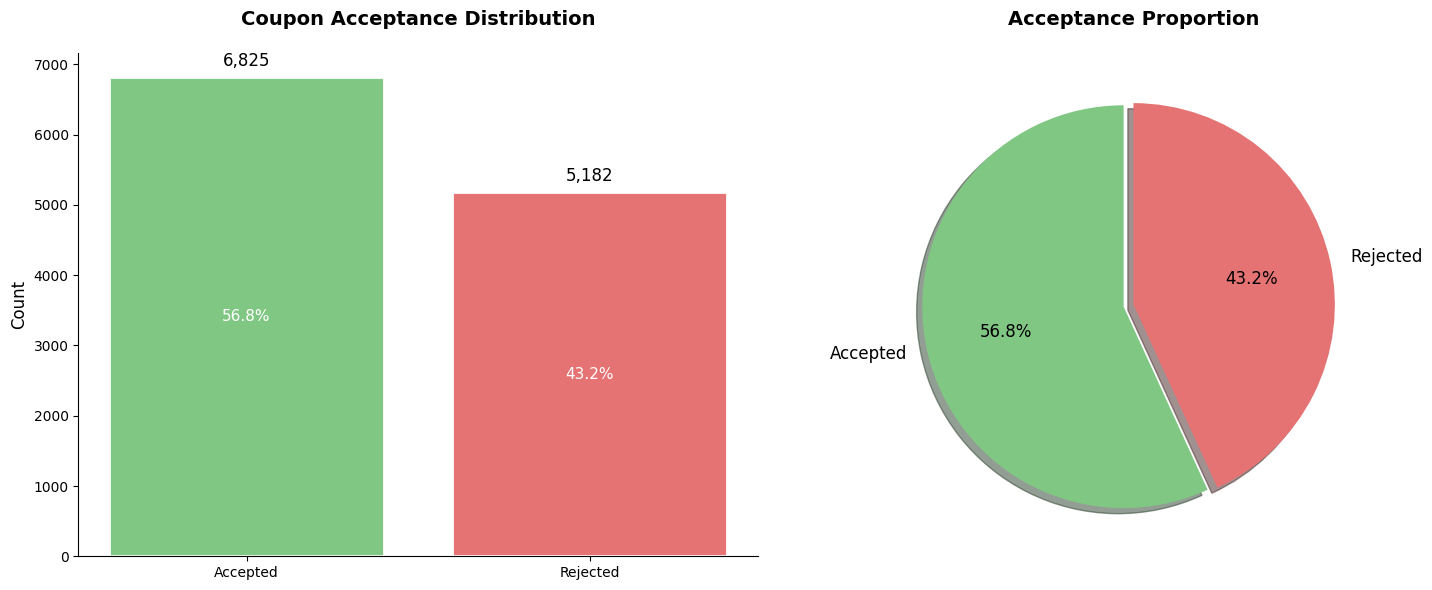


✓ Majority (56.8%) accepted coupons


In [5]:
# Overall Acceptance Rate
total = len(df_clean)
accepted = (df_clean['Y'] == 1).sum()
acc_rate = accepted / total * 100

print(f"Total: {total:,}")
print(f"Accepted: {accepted:,} ({acc_rate:.1f}%)")
print(f"Rejected: {total - accepted:,} ({100-acc_rate:.1f}%)")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart
bars = ax1.bar(['Accepted', 'Rejected'], [accepted, total - accepted], 
               color=[COLORS['accept'], COLORS['reject']], edgecolor='white', linewidth=2)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Coupon Acceptance Distribution', fontsize=14, fontweight='bold', pad=20)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 100, f'{int(height):,}',
            ha='center', va='bottom', fontsize=12)
    ax1.text(bar.get_x() + bar.get_width()/2., height/2, f'{height/total*100:.1f}%',
            ha='center', va='center', fontsize=11, color='white')

# Pie chart
ax2.pie([accepted, total - accepted], labels=['Accepted', 'Rejected'], autopct='%1.1f%%',
        colors=[COLORS['accept'], COLORS['reject']], startangle=90, explode=(0.05, 0), shadow=True,
        textprops={'fontsize': 12})
ax2.set_title('Acceptance Proportion', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print(f"\n✓ Majority ({acc_rate:.1f}%) accepted coupons")

### 5. Use a bar plot to visualize the `coupon` column

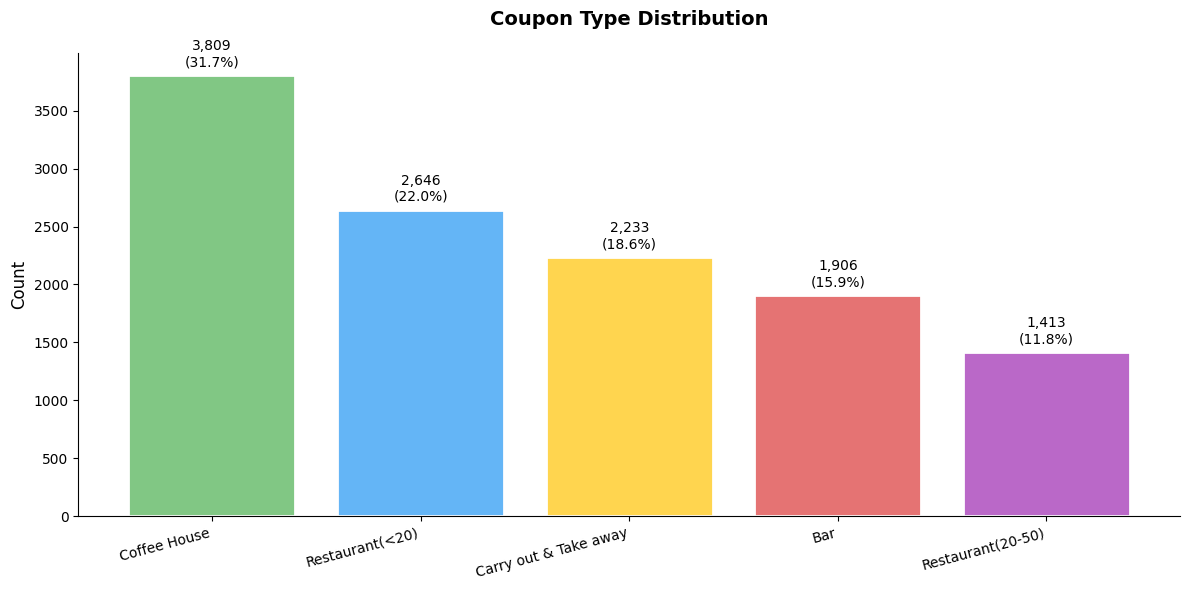

In [6]:
# Coupon Distribution
coupon_counts = df_clean['coupon'].value_counts()

fig, ax = plt.subplots(figsize=(12, 6))
colors_list = [COLORS['accept'], COLORS['tertiary'], COLORS['secondary'], COLORS['reject'], COLORS['primary']]
bars = ax.bar(coupon_counts.index, coupon_counts.values, color=colors_list, edgecolor='white', linewidth=2)

ax.set_ylabel('Count', fontsize=12)
ax.set_title('Coupon Type Distribution', fontsize=14, fontweight='bold', pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 50, 
            f'{int(height):,}\n({height/len(df_clean)*100:.1f}%)',
            ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

### 6. Use a histogram to visualize the temperature column

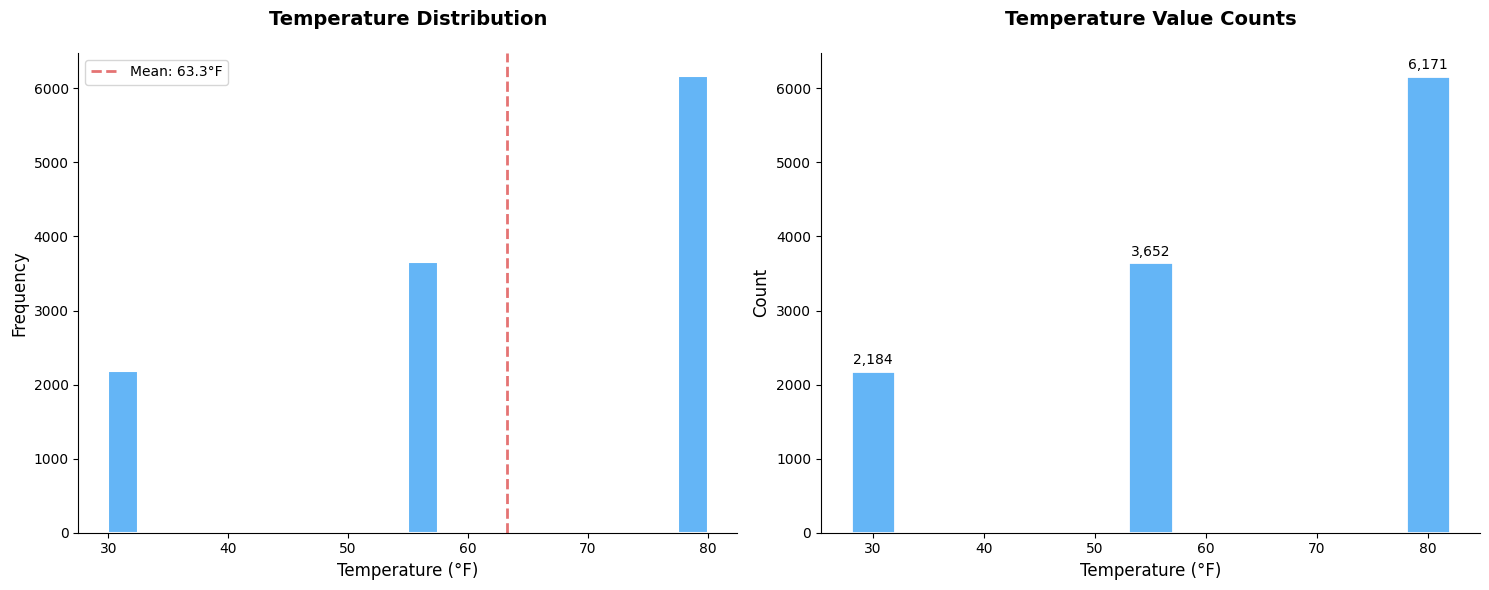

Temperature values: [np.int64(30), np.int64(55), np.int64(80)]
Most common: 80°F (6,171 observations)


In [7]:
# Temperature Distribution
temp_stats = df_clean['temperature'].describe()
temp_counts = df_clean['temperature'].value_counts().sort_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histogram
ax1.hist(df_clean['temperature'], bins=20, color=COLORS['tertiary'], edgecolor='white', linewidth=1.5)
ax1.set_xlabel('Temperature (°F)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Temperature Distribution', fontsize=14, fontweight='bold', pad=20)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.axvline(temp_stats['mean'], color=COLORS['reject'], linestyle='--', linewidth=2, label=f'Mean: {temp_stats["mean"]:.1f}°F')
ax1.legend()

# Bar chart of actual values
ax2.bar(temp_counts.index, temp_counts.values, color=COLORS['tertiary'], edgecolor='white', linewidth=2, width=4)
ax2.set_xlabel('Temperature (°F)', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Temperature Value Counts', fontsize=14, fontweight='bold', pad=20)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

for temp, count in temp_counts.items():
    ax2.text(temp, count + 50, f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print(f"Temperature values: {sorted(df_clean['temperature'].unique())}")
print(f"Most common: {temp_counts.idxmax()}°F ({temp_counts.max():,} observations)")

---
## Bar Coupon Analysis

Investigating acceptance patterns for bar coupons specifically.

### 1. Create a new DataFrame that contains just the bar coupons

In [8]:
# Bar Coupons Dataset
bar_coupons = df_clean[df_clean['coupon'] == 'Bar'].copy()

print(f"Total dataset: {len(df_clean):,}")
print(f"Bar coupons: {len(bar_coupons):,} ({len(bar_coupons)/len(df_clean)*100:.1f}%)")

bar_acc = (bar_coupons['Y'] == 1).sum() / len(bar_coupons) * 100
overall_acc = (df_clean['Y'] == 1).sum() / len(df_clean) * 100
print(f"\nBar acceptance: {bar_acc:.1f}%")
print(f"Overall acceptance: {overall_acc:.1f}%")
print(f"Difference: {bar_acc - overall_acc:+.1f} pp")

Total dataset: 12,007
Bar coupons: 1,906 (15.9%)

Bar acceptance: 41.2%
Overall acceptance: 56.8%
Difference: -15.7 pp


In [9]:
# Helper function for comparisons
def compare_groups(group1, group2, name1, name2, title):
    """Compare acceptance rates between two groups"""
    acc1 = (group1['Y'] == 1).sum() / len(group1) * 100
    acc2 = (group2['Y'] == 1).sum() / len(group2) * 100
    diff = acc1 - acc2
    
    print(f"{name1} (n={len(group1):,}): {acc1:.1f}%")
    print(f"{name2} (n={len(group2):,}): {acc2:.1f}%")
    print(f"Difference: {diff:+.1f} pp\n")
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Acceptance rate comparison
    bars = ax1.bar([name1, name2], [acc1, acc2], 
                   color=[COLORS['primary'], COLORS['secondary']], edgecolor='white', linewidth=2)
    ax1.set_ylabel('Acceptance Rate (%)', fontsize=12)
    ax1.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax1.set_ylim(0, 100)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    for bar, rate, n in zip(bars, [acc1, acc2], [len(group1), len(group2)]):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 2,
                f'{rate:.1f}%', ha='center', va='bottom', fontsize=12)
        ax1.text(bar.get_x() + bar.get_width()/2., -5,
                f'(n={n:,})', ha='center', va='top', fontsize=10)
    
    # Count comparison
    x = np.arange(2)
    width = 0.35
    accepted = [(group1['Y'] == 1).sum(), (group2['Y'] == 1).sum()]
    rejected = [(group1['Y'] == 0).sum(), (group2['Y'] == 0).sum()]
    
    ax2.bar(x - width/2, accepted, width, label='Accepted', 
            color=COLORS['accept'], edgecolor='white', linewidth=2)
    ax2.bar(x + width/2, rejected, width, label='Rejected', 
            color=COLORS['reject'], edgecolor='white', linewidth=2)
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_title('Distribution', fontsize=14, fontweight='bold', pad=20)
    ax2.set_xticks(x)
    ax2.set_xticklabels([name1, name2])
    ax2.legend()
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return acc1, acc2, diff

### 2. What proportion of bar coupons were accepted?

In [10]:
# Already shown above in dataset creation - bar acceptance: ~41%

### 3. Compare acceptance: ≤3 visits/month vs >3 visits/month

≤3 times/month (n=1,713): 37.2%
>3 times/month (n=193): 76.2%
Difference: -38.9 pp



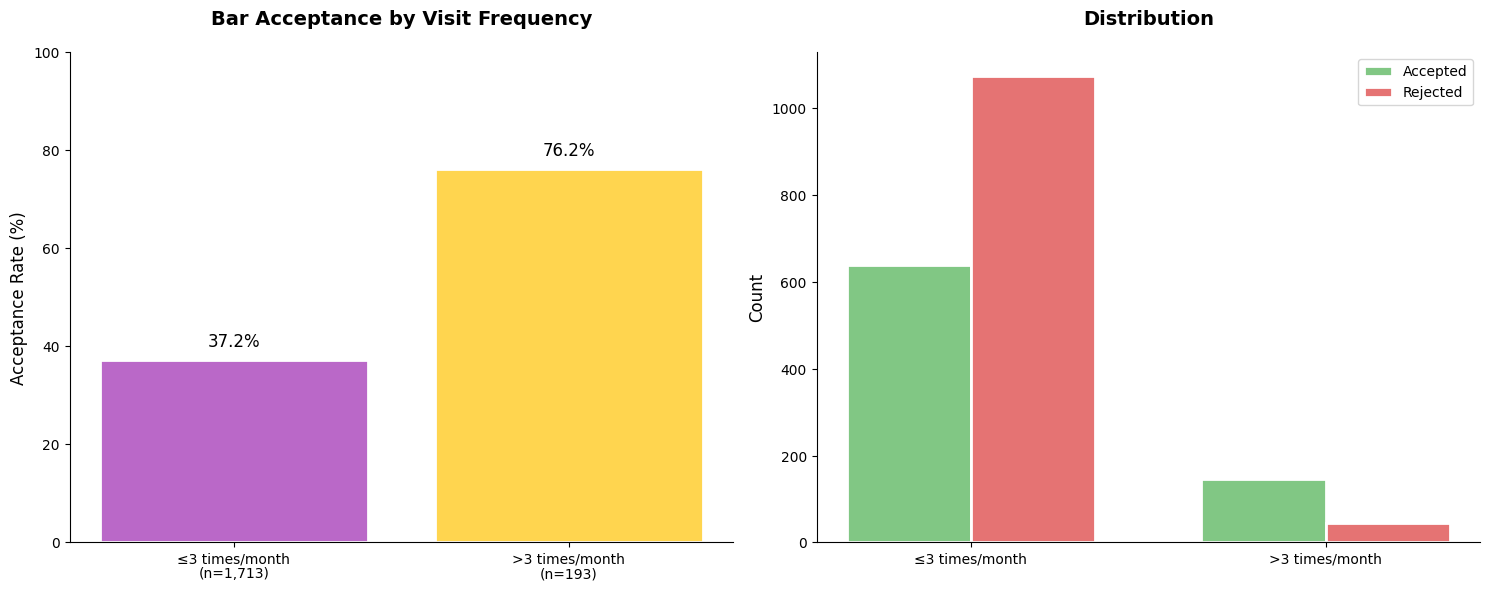

(np.float64(37.244600116754235),
 np.float64(76.16580310880829),
 np.float64(-38.921202992054056))

In [11]:
bar_low = bar_coupons[bar_coupons['Bar'].isin(['never', 'less1', '1~3'])]
bar_high = bar_coupons[bar_coupons['Bar'].isin(['4~8', 'gt8'])]

compare_groups(bar_low, bar_high, '≤3 times/month', '>3 times/month', 
               'Bar Acceptance by Visit Frequency')

### 4. Compare acceptance: >1/month AND age >25 vs all others

Bar >1/mo & Age >25 (n=833): 54.6%
All Others (n=1,073): 30.8%
Difference: +23.9 pp



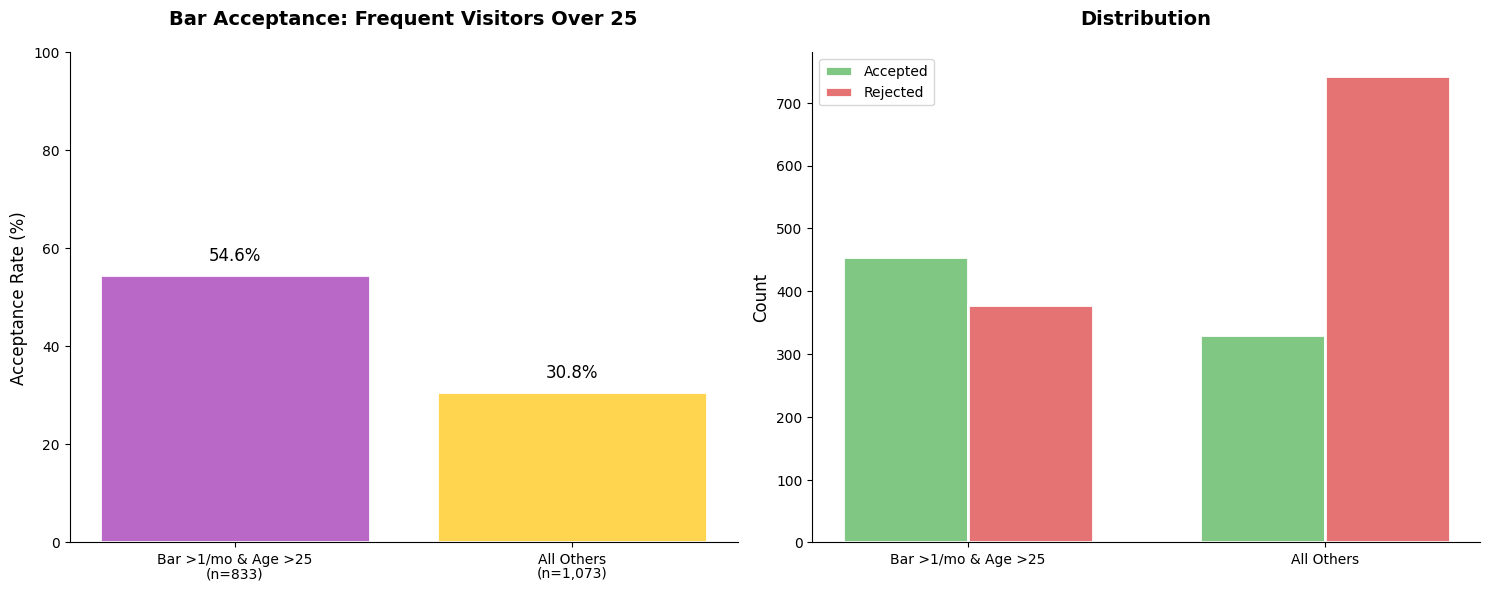

(np.float64(54.621848739495796),
 np.float64(30.75489282385834),
 np.float64(23.866955915637455))

In [12]:
group1 = bar_coupons[
    (bar_coupons['Bar'].isin(['less1', '1~3', '4~8', 'gt8'])) & 
    (bar_coupons['age'].isin(['26', '31', '36', '41', '46', '50plus']))
]
group2 = bar_coupons[~bar_coupons.index.isin(group1.index)]

compare_groups(group1, group2, 'Bar >1/mo & Age >25', 'All Others',
               'Bar Acceptance: Frequent Visitors Over 25')

### 5. Compare acceptance: >1/month + no kids + not farming

Bar >1/mo + No kids + Not farming (n=1,018): 59.3%
All Others (n=888): 20.4%
Difference: +38.9 pp



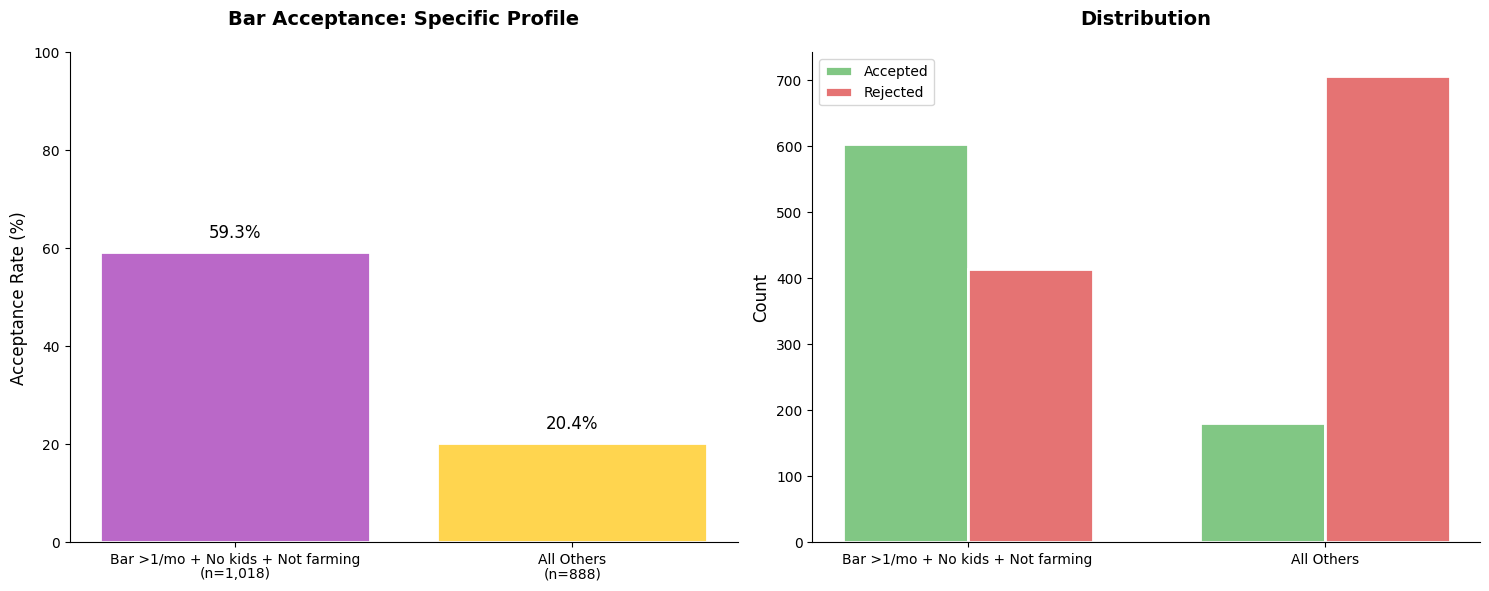

(np.float64(59.3320235756385),
 np.float64(20.382882882882882),
 np.float64(38.94914069275562))

In [13]:
group1 = bar_coupons[
    (bar_coupons['Bar'].isin(['less1', '1~3', '4~8', 'gt8'])) & 
    (bar_coupons['passanger'] != 'Kid(s)') &
    (bar_coupons['occupation'] != 'Farming Fishing & Forestry')
]
group2 = bar_coupons[~bar_coupons.index.isin(group1.index)]

compare_groups(group1, group2, 'Bar >1/mo + No kids + Not farming', 'All Others',
               'Bar Acceptance: Specific Profile')

### 6. Compare complex OR conditions

Meeting ≥1 condition (n=1,183): 54.8%
Meeting none (n=723): 18.9%
Difference: +35.8 pp



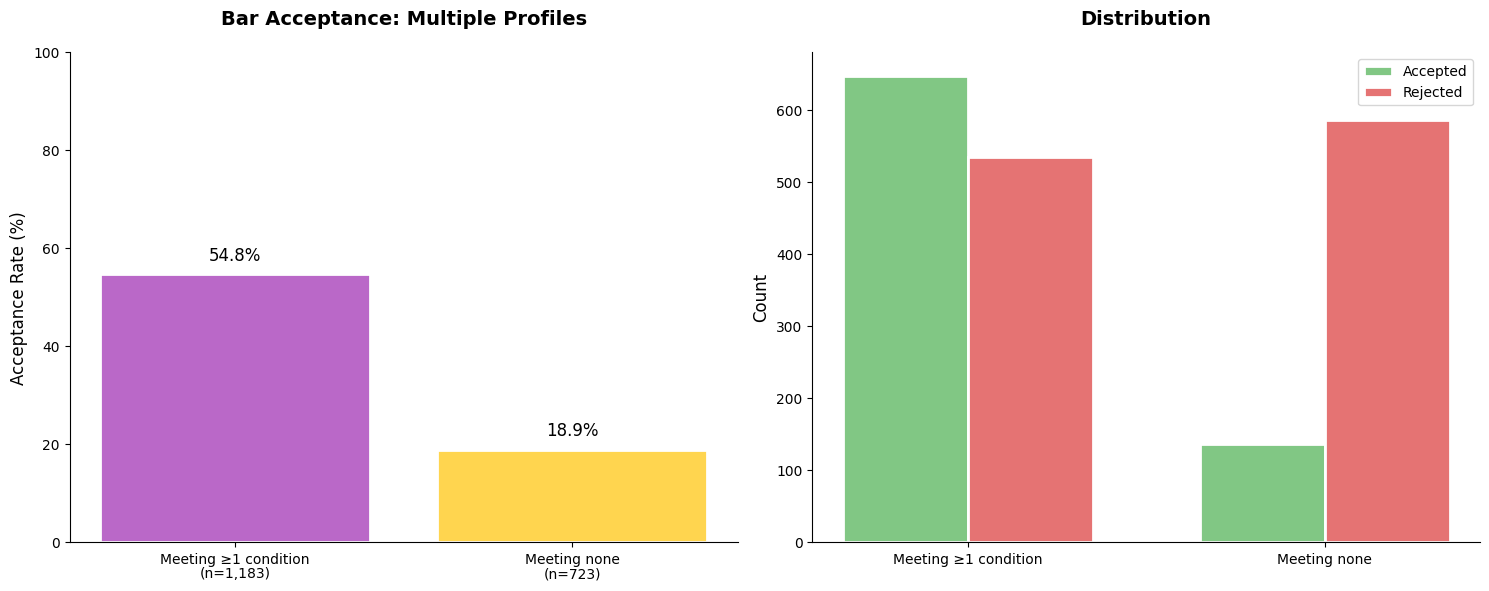

Conditions:
  1. Bar >1/mo + No kids + Not widowed: 1,017
  2. Bar >1/mo + Age <30: 522
  3. Cheap rest >4/mo + Income <$50K: 333


In [14]:
cond1 = (bar_coupons['Bar'].isin(['less1', '1~3', '4~8', 'gt8'])) & \
        (bar_coupons['passanger'] != 'Kid(s)') & \
        (bar_coupons['maritalStatus'] != 'Widowed')

cond2 = (bar_coupons['Bar'].isin(['less1', '1~3', '4~8', 'gt8'])) & \
        (bar_coupons['age'].isin(['below21', '21', '26']))

cond3 = (bar_coupons['RestaurantLessThan20'].isin(['4~8', 'gt8'])) & \
        (bar_coupons['income'].isin(['Less than $12500', '$12500 - $24999', '$25000 - $37499', '$37500 - $49999']))

group1 = bar_coupons[cond1 | cond2 | cond3]
group2 = bar_coupons[~bar_coupons.index.isin(group1.index)]

compare_groups(group1, group2, 'Meeting ≥1 condition', 'Meeting none',
               'Bar Acceptance: Multiple Profiles')

print("Conditions:")
print(f"  1. Bar >1/mo + No kids + Not widowed: {cond1.sum():,}")
print(f"  2. Bar >1/mo + Age <30: {cond2.sum():,}")
print(f"  3. Cheap rest >4/mo + Income <$50K: {cond3.sum():,}")

### 7. Hypothesis: Bar Coupon Acceptors

**Key Finding:** Visit frequency is the dominant predictor (+39pp difference)

**Profile of acceptors:**
- Visit bars >3 times/month (76% acceptance)
- Age 25+ with regular bar visits (55% vs 19%)
- No children present (social context matters)

**Core insight:** Bar coupons reinforce existing habits rather than creating new ones. The 39pp gap between frequent and infrequent visitors shows coupons work best on established customers.

**Strategy:** Target drivers with proven bar-visiting patterns. Avoid wasting coupons on non-bar-goers - focus on timing existing customers' visits.

---
## Independent Investigation: Coffee House Coupons

Analyzing coffee house coupons as a contrast to bar coupons - different time sensitivity and social dynamics expected.

In [15]:
# Coffee House Analysis
coffee = df_clean[df_clean['coupon'] == 'Coffee House'].copy()
overall_acc = (df_clean['Y'] == 1).sum() / len(df_clean) * 100
coffee_acc = (coffee['Y'] == 1).sum() / len(coffee) * 100

print(f"Coffee coupons: {len(coffee):,} ({len(coffee)/len(df_clean)*100:.1f}% of dataset)")
print(f"Acceptance: {coffee_acc:.1f}% (vs {overall_acc:.1f}% overall)")
print(f"Difference: {coffee_acc - overall_acc:+.1f} pp\n")

# Multi-factor quick analysis
factors = {
    'Visit Frequency': {
        '≤3/mo': coffee[coffee['CoffeeHouse'].isin(['never', 'less1', '1~3'])],
        '>3/mo': coffee[coffee['CoffeeHouse'].isin(['4~8', 'gt8'])]
    },
    'Time': {t: coffee[coffee['time'] == t] for t in coffee['time'].unique()},
    'Passenger': {p: coffee[coffee['passanger'] == p] for p in coffee['passanger'].unique()},
    'Destination': {d: coffee[coffee['destination'] == d] for d in coffee['destination'].unique()}
}

for factor_name, groups in factors.items():
    print(f"{factor_name}:")
    results = {}
    for name, group in groups.items():
        acc = (group['Y'] == 1).sum() / len(group) * 100
        results[name] = (acc, len(group))
        print(f"  {name:20s} (n={len(group):4,}): {acc:5.1f}%")
    
    # Calculate range
    rates = [r[0] for r in results.values()]
    print(f"  Range: {max(rates) - min(rates):.1f} pp\n")

Coffee coupons: 3,809 (31.7% of dataset)
Acceptance: 49.6% (vs 56.8% overall)
Difference: -7.3 pp

Visit Frequency:
  ≤3/mo                (n=2,960):  44.5%
  >3/mo                (n= 849):  67.3%
  Range: 22.8 pp

Time:
  10AM                 (n= 856):  63.4%
  2PM                  (n= 758):  54.5%
  6PM                  (n=1,038):  41.0%
  7AM                  (n= 875):  44.0%
  10PM                 (n= 282):  42.9%
  Range: 22.4 pp

Passenger:
  Friend(s)            (n=1,173):  59.7%
  Alone                (n=2,154):  43.4%
  Kid(s)               (n= 192):  46.9%
  Partner              (n= 290):  56.6%
  Range: 16.3 pp

Destination:
  No Urgent Place      (n=2,048):  57.7%
  Home                 (n= 886):  36.2%
  Work                 (n= 875):  44.0%
  Range: 21.5 pp



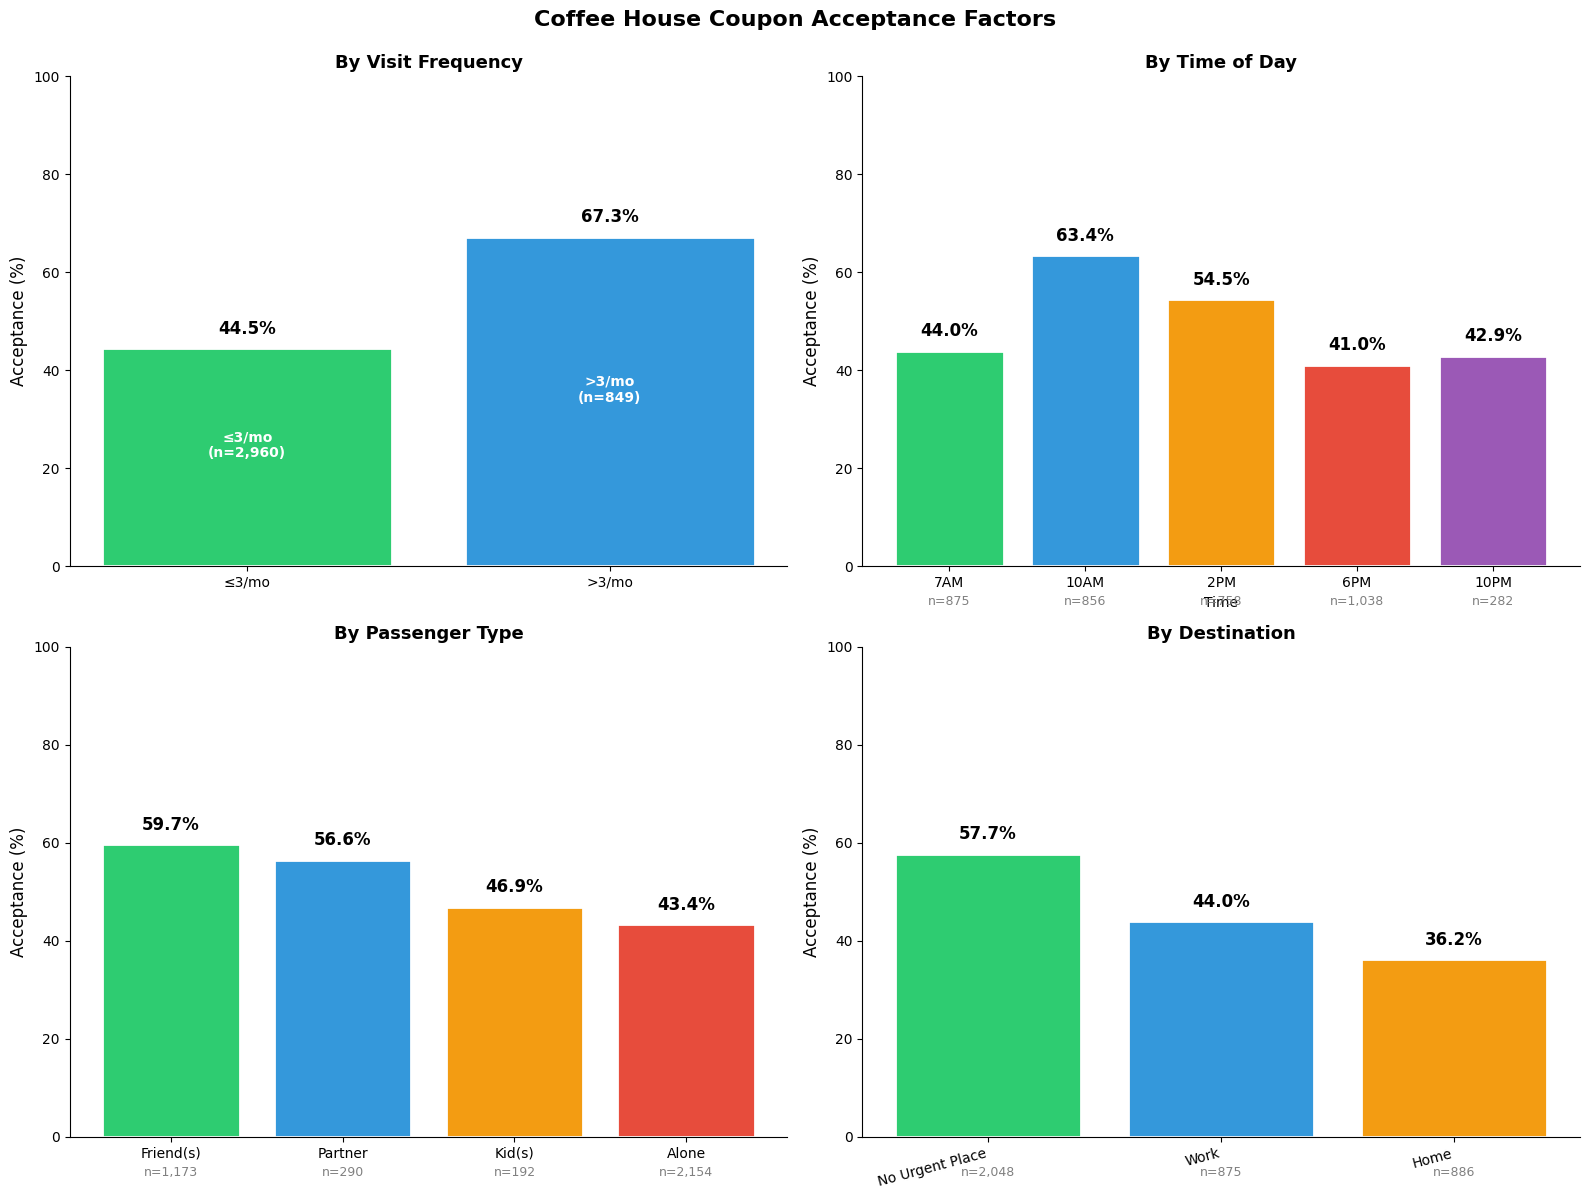

In [16]:
# Visualize key coffee house factors
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Coffee House Coupon Acceptance Factors', fontsize=16, fontweight='bold', y=0.995)

# Better color palette - distinct colors
CHART_COLORS = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c', '#9b59b6', '#1abc9c']

# 1. Visit Frequency
freq_data = {'≤3/mo': coffee[coffee['CoffeeHouse'].isin(['never', 'less1', '1~3'])],
             '>3/mo': coffee[coffee['CoffeeHouse'].isin(['4~8', 'gt8'])]}
freq_labels, freq_groups = list(freq_data.keys()), list(freq_data.values())
freq_rates = [(g['Y']==1).sum()/len(g)*100 for g in freq_groups]
freq_counts = [len(g) for g in freq_groups]

bars1 = ax1.bar(freq_labels, freq_rates, color=CHART_COLORS[:2], edgecolor='white', linewidth=2)
ax1.set_ylabel('Acceptance (%)', fontsize=12)
ax1.set_title('By Visit Frequency', fontsize=13, fontweight='bold')
ax1.set_ylim(0, 100)
ax1.spines[['top','right']].set_visible(False)
for bar, rate, n, label in zip(bars1, freq_rates, freq_counts, freq_labels):
    ax1.text(bar.get_x()+bar.get_width()/2, rate+3, f'{rate:.1f}%', 
             ha='center', fontsize=12, fontweight='bold')
    ax1.text(bar.get_x()+bar.get_width()/2, rate/2, f'{label}\n(n={n:,})', 
             ha='center', fontsize=10, color='white', fontweight='bold')

# 2. Time of Day (chronological order)
time_order = ['7AM', '10AM', '2PM', '6PM', '10PM']
time_groups = [coffee[coffee['time']==t] for t in time_order]
time_rates = [(g['Y']==1).sum()/len(g)*100 for g in time_groups]
time_counts = [len(g) for g in time_groups]

bars2 = ax2.bar(time_order, time_rates, color=CHART_COLORS[:5], edgecolor='white', linewidth=2)
ax2.set_ylabel('Acceptance (%)', fontsize=12)
ax2.set_title('By Time of Day', fontsize=13, fontweight='bold')
ax2.set_ylim(0, 100)
ax2.spines[['top','right']].set_visible(False)
for bar, rate, n in zip(bars2, time_rates, time_counts):
    ax2.text(bar.get_x()+bar.get_width()/2, rate+3, f'{rate:.1f}%', 
             ha='center', fontsize=12, fontweight='bold')
ax2.set_xlabel('Time', fontsize=10)
# Add sample sizes below x-axis
for i, (time, n) in enumerate(zip(time_order, time_counts)):
    ax2.text(i, -8, f'n={n:,}', ha='center', fontsize=9, color='gray')

# 3. Passenger Type (sorted by acceptance rate)
pass_data = {p: coffee[coffee['passanger']==p] for p in coffee['passanger'].unique()}
pass_rates = {k: (v['Y']==1).sum()/len(v)*100 for k, v in pass_data.items()}
pass_sorted = sorted(pass_rates.items(), key=lambda x: x[1], reverse=True)
pass_labels = [x[0] for x in pass_sorted]
pass_rate_vals = [x[1] for x in pass_sorted]
pass_counts = [len(pass_data[x[0]]) for x in pass_sorted]

bars3 = ax3.bar(range(len(pass_labels)), pass_rate_vals, color=CHART_COLORS[:len(pass_labels)], 
                edgecolor='white', linewidth=2)
ax3.set_ylabel('Acceptance (%)', fontsize=12)
ax3.set_title('By Passenger Type', fontsize=13, fontweight='bold')
ax3.set_ylim(0, 100)
ax3.spines[['top','right']].set_visible(False)
ax3.set_xticks(range(len(pass_labels)))
ax3.set_xticklabels(pass_labels, rotation=0, ha='center')
for bar, rate in zip(bars3, pass_rate_vals):
    ax3.text(bar.get_x()+bar.get_width()/2, rate+3, f'{rate:.1f}%', 
             ha='center', fontsize=12, fontweight='bold')
# Add sample sizes below
for i, n in enumerate(pass_counts):
    ax3.text(i, -8, f'n={n:,}', ha='center', fontsize=9, color='gray')

# 4. Destination (sorted by acceptance rate)
dest_data = {d: coffee[coffee['destination']==d] for d in coffee['destination'].unique()}
dest_rates = {k: (v['Y']==1).sum()/len(v)*100 for k, v in dest_data.items()}
dest_sorted = sorted(dest_rates.items(), key=lambda x: x[1], reverse=True)
dest_labels = [x[0] for x in dest_sorted]
dest_rate_vals = [x[1] for x in dest_sorted]
dest_counts = [len(dest_data[x[0]]) for x in dest_sorted]

bars4 = ax4.bar(range(len(dest_labels)), dest_rate_vals, color=CHART_COLORS[:len(dest_labels)], 
                edgecolor='white', linewidth=2)
ax4.set_ylabel('Acceptance (%)', fontsize=12)
ax4.set_title('By Destination', fontsize=13, fontweight='bold')
ax4.set_ylim(0, 100)
ax4.spines[['top','right']].set_visible(False)
ax4.set_xticks(range(len(dest_labels)))
ax4.set_xticklabels(dest_labels, rotation=15, ha='right')
for bar, rate in zip(bars4, dest_rate_vals):
    ax4.text(bar.get_x()+bar.get_width()/2, rate+3, f'{rate:.1f}%', 
             ha='center', fontsize=12, fontweight='bold')
# Add sample sizes below
for i, n in enumerate(dest_counts):
    ax4.text(i, -8, f'n={n:,}', ha='center', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

### Coffee House Analysis Summary

**Strongest predictors:**
1. Visit frequency: +23pp (weaker than bars' +39pp)
2. Time of day: +22pp range (10AM peak at 63%)
3. Passenger type: +16pp (social > alone, opposite of bars)
4. Destination: +22pp (leisure > commute)

**Key differences from bars:**
- Time-sensitive: 10AM (63%) >> 6PM (41%)
- Social activity: Friends (60%) > Alone (43%)
- Lower-income more receptive (reverse of expected)
- Weaker frequency effect vs bars

**Insight:** Coffee coupons about convenience and social experience, not just habit reinforcement. Mid-morning social contexts drive acceptance.

---
## Conclusions

**Overall acceptance:** 57% of drivers accept coupons

**Key learnings:**

1. **Visit frequency dominates** - Existing customers 2-4x more likely to accept
2. **Context matters** - Time, passengers, and destination significantly impact acceptance
3. **Coupon type differences**:
   - Bars: Habit reinforcement, solo acceptable
   - Coffee: Time-sensitive, social preferred

**Strategy recommendations:**
- Target existing customers (highest ROI)
- Time delivery appropriately (coffee: mornings, bars: evenings)
- Consider social context (coffee with friends, bars solo OK)
- Don't waste resources trying to convert non-customers